<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ADCEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [552]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm
import pandas as pd
import matplotlib as mpl
from collections import defaultdict

# sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = [12., 8.0]


In [553]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Create Samples

In [554]:
d = 3
num_samples = 10000

In [555]:
mu = [0]*d
cov = np.eye(d)

In [556]:
kind = 'hex'
# kind = 'scatter'

In [557]:
Z = np.random.multivariate_normal(mu, cov, num_samples)
N1 = np.random.multivariate_normal(mu,  cov, num_samples)
N2 = np.random.multivariate_normal(mu,  cov, num_samples)

In [558]:
X_prior = Z + .1 * N1
Y_prior = Z + .1 * N2

In [559]:
def draw_correlations(A, B, prnt=True, plot=False):
  eziz = []
  for i in range(A.shape[-1]):
    corr = np.corrcoef(A[:,i], B[:,i])[0,1]
    eziz.append(corr)
    if prnt:
      print(f'correlations {i}th entry: {corr}')
    if plot:
      sns.jointplot(A[:, i], B[:, i], kind=kind)
  return eziz

In [560]:
t = draw_correlations(X_prior, Y_prior)

correlations 0th entry: 0.9902320262556052
correlations 1th entry: 0.9900786568967288
correlations 2th entry: 0.9901781800190351


In [561]:
non_linearity = np.exp

In [562]:
thetaX = [0] * d
thetaX[2] = np.pi/3
rot_axis_X = np.array([1, 1, 1])
rotX = Rotation.from_rotvec(thetaX * rot_axis_X)
X = rotX.apply(non_linearity(X_prior))

In [563]:
print(f'X: mean {np.mean(X, axis=0)}, std {np.std(X, axis=0)}')

X: mean [-0.59311153  2.26480151  1.60304996], std [2.1216429  2.16526651 2.04103035]


In [564]:
thetaY = [0] * d
thetaY[0] = -np.pi / 2
thetaY[1] = -np.pi / 6
rot_axis_Y = np.array([1, 1, 1])
rotY = Rotation.from_rotvec(thetaY * rot_axis_Y)
Y = rotY.apply(Y_prior)

In [565]:
print(f'X: mean {np.mean(Y, axis=0)}, std {np.std(Y, axis=0)}')

X: mean [ 0.0071089  -0.02621746 -0.00123488], std [1.00895105 1.01416003 1.00064587]


$X, Y$ are rotations of a linear combination of $Z + \lambda N1$ and $Z + \lambda N2$ respectively, where $Z, N1, N2$ each drawn from a multivariate gaussian with 0 mean and unit covariance.
$\lambda=0.1$ and the rotations are different and are performed around different axes.

In [566]:
draw_correlations(X,Y)

correlations 0th entry: 0.12793930511031879
correlations 1th entry: 0.2496874896076383
correlations 2th entry: -0.04550314215518664


[0.12793930511031879, 0.2496874896076383, -0.04550314215518664]

### create pytorch model class and train and eval functions

notice there is no normalization at the final output. Normalization is performed with apply_transform function

In [567]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, lr=0.01, activation=None):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      # nn.init.xavier_normal_(self.fc1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      # nn.init.xavier_normal_(self.fc2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=output_size, )
      
      self.learning_rate = lr
      self._criterion = nn.MSELoss()
      self._optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
      self.activation = activation
      
  def forward(self, x):
      u = self.fc1(x)
      u = self.bn1(u)
      if self.activation is not None:
        u = self.activation(u)
      u = self.fc2(u)
      return u
    
  def get_criterion(self):
      return self._criterion

  def get_optimizer(self):
      return self._optimizer
  

In [568]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size, output_size, lr=0.01, activation=None):
        super(MlpNet, self).__init__()
        if activation is None:
          activation = nn.Identity()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    activation(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                ))
        self.layers.append(nn.Sequential(
            
        ))
        self.layers = nn.ModuleList(layers)
        self.learning_rate = lr
        self._criterion = nn.MSELoss()
        self._optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_criterion(self):
        return self._criterion

    def get_optimizer(self):
        return self._optimizer

In [569]:
def make_train_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    optimizer = model.get_optimizer()
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [570]:
def make_eval_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    def eval_step(x, y):
        # Sets model to TRAIN mode
        model.eval()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return eval_step

In [571]:
def apply_transform(model, inp, zero_mean=True, unit_var=True):
  model.eval()
  out = model(inp)
  if zero_mean:
    out -= out.mean(axis=0)
  if unit_var:
    out = torch.div(out, out.std(axis=0))
  return out

In [572]:
def learn(loader, _x_model, _y_model, _x_train_step, _y_train_step, _max_samples=np.inf):
  U = []
  V = []
  losses_x = []
  losses_y = []

  sample_count = 0
  for x_batch, y_batch in loader:
    sample_count += len(x_batch)
    if sample_count > _max_samples:
      break
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    transformed_y_batch = apply_transform(_y_model, y_batch)
    loss_x = _x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    loss_y = _y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)
  U = torch.cat(U)
  V = torch.cat(V)
  # UV = U * V
  # corr = UV.mean(axis=0).item()
  corr = draw_correlations(U.detach().numpy(), V.detach().numpy(), False, False)[0]

  return corr, np.mean(losses_x), np.mean(losses_y)


In [573]:
def evaluate(loader, _x_model, _y_model, _x_eval_step, _y_eval_step):
  # X = []
  # Y = []
  U = []
  V = []
  val_loss_x = []
  val_loss_y = []
  with torch.no_grad(): 
    for x_val, y_val in loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      transformed_y_batch = apply_transform(_y_model, y_val)
      transformed_x_batch = apply_transform(_x_model, x_val)

      # X.append(x_val)
      # Y.append(y_val)
      U.append(transformed_x_batch)
      V.append(transformed_y_batch)

      val_loss_x.append(_x_eval_step(x_val, transformed_y_batch))
      val_loss_y.append(_y_eval_step(y_val, transformed_x_batch))
  # X = torch.cat(X)
  # Y = torch.cat(Y)
  U = torch.cat(U)
  V = torch.cat(V)
  # UV = U * V
  # return (U, V), np.mean(val_loss_x), np.mean(val_loss_y)
  # corr = UV.mean(axis=0).item()
  corr = draw_correlations(U, V, False, False)[0]
  return corr, (U, V), np.mean(val_loss_x), np.mean(val_loss_y)


In [574]:
def build_models(cls, *args):
  model1 = cls(*args)
  model2 = cls(*args)

  train_step1 = make_train_step(model1)
  train_step2 = make_train_step(model2)

  eval_step1 = make_eval_step(model1)
  eval_step2 = make_eval_step(model2)
  return model1, model2, train_step1, train_step2, eval_step1, eval_step2


### create data split

In [575]:
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y).float()

In [576]:
from sklearn.model_selection import train_test_split

In [577]:
X_train, X_test, Y_train, Y_test = train_test_split(x_tensor, y_tensor, test_size=0.1, random_state=42)

In [578]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_test, Y_test)

In [579]:
# train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

In [580]:
max_samples = len(train_dataset) // 1

In [581]:
max_samples

9000

In [582]:
wanted_dim = 1

In [583]:
hidden_size = 8
max_epochs = 10
lr = 0.001
act = None
act = F.relu
# batch_size = len(train_dataset) // 2
batch_size = 32

In [584]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

In [585]:
x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
  build_models(Model, X.shape[-1], hidden_size, wanted_dim, lr, act)

scores = defaultdict(list)
losses = defaultdict(list)

last_score, (Us, Vs) , val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step)
training_first_score, (Us, Vs) , train_x_loss, train_y_loss = evaluate(train_loader, x_model, y_model, x_eval_step, y_eval_step)

scores['validation'].append(last_score)
# scores['training'].append(training_first_score)
scores['epoch'].append(-1)

losses['x_model_validation'].append(val_x_loss)
losses['y_model_validation'].append(val_y_loss)
losses['x_model_training'].append(train_x_loss)
losses['y_model_training'].append(train_y_loss)
losses['epoch'].append(-1)

for epoch in range(max_epochs):
  # train
  train_score, train_x_loss, train_y_loss = learn(train_loader, x_model, y_model, x_train_step, y_train_step, _max_samples=max_samples)
  
  # scores['training'].append(train_score)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  
  scores['epoch'].append(epoch)
  losses['epoch'].append(epoch)

  # validate
  current_score, (Us, Vs), val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step)
  scores['validation'].append(current_score)
  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)

  # if last_score > current_score:
  #   break
  print(current_score)
  last_score = current_score
        

0.8280621519743598
0.8773166879878441
0.9030934689427355
0.920815182762165
0.9346994404741085
0.945724292463751
0.9542228502152255
0.9606126204008689
0.9652339099285114
0.9685328865834911


Find linear CCA result for wanted dim

In [586]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3)
X_train_c, Y_train_c = cca.fit_transform(X_train, Y_train)
X_c, Y_c = cca.transform(X_test, Y_test)
print(f'X_c: mean {np.mean(X_c, axis=0)}, std {np.std(X_c, axis=0)}')
print(f'Y_c: mean {np.mean(Y_c, axis=0)}, std {np.std(Y_c, axis=0)}')

CCAtrain = draw_correlations(X_train_c, Y_train_c, False)
CCAtest = draw_correlations(X_c, Y_c)

X_c: mean [-0.03112446  0.02488793 -0.02757477], std [0.98753767 1.0824386  0.99481412]
Y_c: mean [-0.01330721  0.02996964  0.00437941], std [1.02032622 0.98122287 0.97672223]
correlations 0th entry: 0.775441161789289
correlations 1th entry: 0.7555415417874296
correlations 2th entry: 0.7517209343573251


In [587]:
# scores['LinearCCA training'] = [max(CCAtrain)] * len(scores['epoch'])
scores['LinearCCA validation'] = [max(CCAtest)] * len(scores['epoch'])
scores['Maximum score'] = [max(draw_correlations(X_prior, Y_prior))] * len(scores['epoch'])

correlations 0th entry: 0.9902320262556052
correlations 1th entry: 0.9900786568967288
correlations 2th entry: 0.9901781800190351


In [588]:
# len(scores['epoch'])

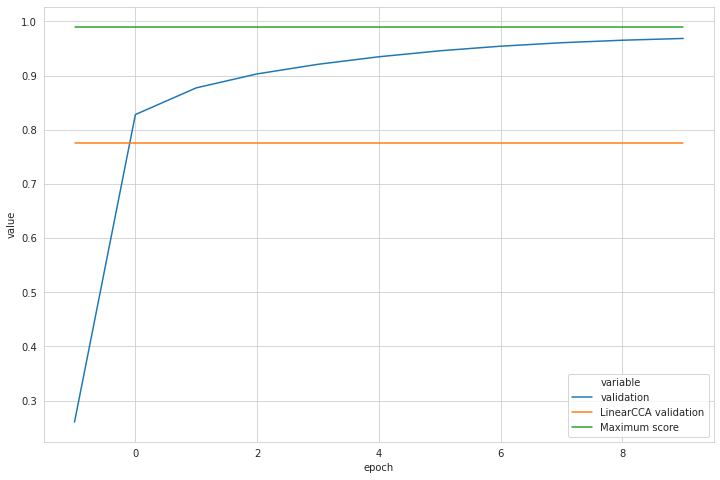

In [589]:
scores_data = pd.DataFrame(scores)
df_scores = pd.melt(scores_data, 'epoch')
g = sns.lineplot('epoch', 'value', 'variable', data=df_scores)


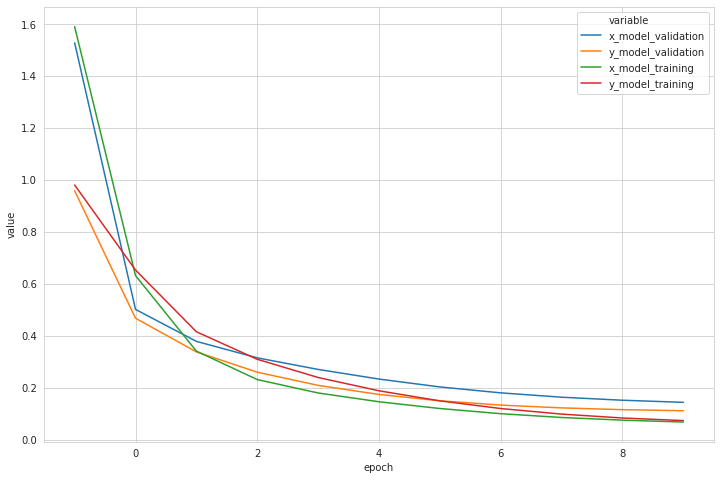

In [590]:
losses_data = pd.DataFrame(losses)
df_losses = pd.melt(losses_data, 'epoch')
sns.lineplot('epoch', 'value', 'variable', data=df_losses)

In [591]:
def learn_orthogonal_initialization(loader, previous_models, new_model):
  # U = []
  # V = []
  # losses_x = []
  # losses_y = []
  for _, y_batch in loader:
    # x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    for model in previous_models:
      transformed_batch = apply_transform(model, y_batch)
    loss_x = x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    loss_y = y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)
  U = torch.cat(U)
  V = torch.cat(V)
  UV = U * V

  return UV.mean(axis=0).item(), np.mean(losses_x), np.mean(losses_y)
